<a href="https://colab.research.google.com/github/SABIN-KUMAR/Major_Project_Model_Train_CNN_Based_Indepth_MobileNetV2_FruitClassification/blob/main/ModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# CELL 1: Mount Google Drive
# ============================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ============================================
# CELL 2: Import All Required Libraries
# ============================================
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [3]:
# ============================================
# CELL 3: Set Configuration Parameters
# ============================================
# UPDATE THIS PATH TO YOUR DATASET LOCATION
base_path = '/content/drive/MyDrive/FinalYearProject/fruits_dataset'  # ← CHANGE THIS TO YOUR DATASET PATH

train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Cleaned dataset paths (no validation folder - we'll create it from train)
cleaned_base_path = os.path.join(base_path, 'cleaned_dataset')
cleaned_train_path = os.path.join(cleaned_base_path, 'train')
cleaned_val_path = os.path.join(cleaned_base_path, 'validation')
cleaned_test_path = os.path.join(cleaned_base_path, 'test')

# Fruit classes
classes = [
    'freshapple',
    'freshbanana',
    'rottenapple',
    'rottenbanana'
]

# Training parameters
IMG_SIZE = 224
MIN_FILE_SIZE = 1024
EPOCHS = 25
BATCH_SIZE = 32

# Fine-tuning parameters
FINE_TUNE = True           # Set to False to skip fine-tuning phase
FINE_TUNE_LAYERS = 30      # Number of top MobileNetV2 layers to unfreeze
FINE_TUNE_EPOCHS = 10      # Extra epochs for fine-tuning
FINE_TUNE_LR = 1e-5        # Lower learning rate for fine-tuning

print("✓ Configuration set!")
print(f"Dataset path: {base_path}")
print(f"Classes: {classes}")
print(f"Training for {EPOCHS} epochs (+ {FINE_TUNE_EPOCHS} fine-tune epochs if enabled)")
print("  ℹ️  Base training capped at 25 epochs; EarlyStopping may halt sooner if val_loss plateaus")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Fine-tuning enabled: {FINE_TUNE}")


✓ Configuration set!
Dataset path: /content/drive/MyDrive/FinalYearProject/fruits_dataset
Classes: ['freshapple', 'freshbanana', 'rottenapple', 'rottenbanana']
Training for 25 epochs (+ 10 fine-tune epochs if enabled)
  ℹ️  Base training capped at 25 epochs; EarlyStopping may halt sooner if val_loss plateaus
Image size: 224x224
Fine-tuning enabled: True


In [4]:
# ============================================
# CELL 4: Define Data Cleaning Functions
# ============================================
def is_valid_image(image_path):
    """Check if image is valid and not corrupted"""
    try:
        img = Image.open(image_path)
        img.verify()

        if os.path.getsize(image_path) < MIN_FILE_SIZE:
            return False

        img_cv = cv2.imread(image_path)
        if img_cv is None:
            return False

        h, w = img_cv.shape[:2]
        if h < 50 or w < 50:
            return False

        return True
    except Exception as e:
        return False

def remove_duplicates(image_list, folder_path):
    """Remove duplicate images using hashing"""
    unique_images = []
    seen_hashes = set()

    for img_name in image_list:
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path)
            img_hash = hash(img.tobytes())

            if img_hash not in seen_hashes:
                seen_hashes.add(img_hash)
                unique_images.append(img_name)
        except:
            continue

    return unique_images

def clean_dataset(source_path, dest_path, split_name):
    """Clean dataset by removing corrupted and duplicate images"""
    print(f"\n{'='*50}")
    print(f"Cleaning {split_name} dataset...")
    print(f"{'='*50}")

    os.makedirs(dest_path, exist_ok=True)
    total_removed = 0
    total_kept = 0

    for fruit_class in classes:
        src_class_path = os.path.join(source_path, fruit_class)
        dest_class_path = os.path.join(dest_path, fruit_class)

        if not os.path.exists(src_class_path):
            print(f"⚠️  {fruit_class}: Source folder not found, skipping...")
            continue

        os.makedirs(dest_class_path, exist_ok=True)

        all_files = [f for f in os.listdir(src_class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        valid_files = []
        for file in all_files:
            if is_valid_image(os.path.join(src_class_path, file)):
                valid_files.append(file)

        unique_files = remove_duplicates(valid_files, src_class_path)

        for file in unique_files:
            shutil.copy2(os.path.join(src_class_path, file),
                        os.path.join(dest_class_path, file))

        removed = len(all_files) - len(unique_files)
        total_removed += removed
        total_kept += len(unique_files)

        print(f"✓ {fruit_class}: {len(unique_files)} kept, {removed} removed")

    print(f"\nTotal: {total_kept} images kept, {total_removed} removed")
    return total_kept

def create_validation_split(train_path, val_path, val_split=0.2):
    """Split training data into train and validation"""
    print(f"\n{'='*50}")
    print("Creating validation split from training data...")
    print(f"{'='*50}")

    os.makedirs(val_path, exist_ok=True)

    for fruit_class in classes:
        train_class_path = os.path.join(train_path, fruit_class)
        val_class_path = os.path.join(val_path, fruit_class)

        if not os.path.exists(train_class_path):
            continue

        os.makedirs(val_class_path, exist_ok=True)

        files = [f for f in os.listdir(train_class_path)
                if os.path.isfile(os.path.join(train_class_path, f))]

        if len(files) == 0:
            continue

        train_files, val_files = train_test_split(
            files, test_size=val_split, random_state=42
        )

        for file in val_files:
            shutil.move(os.path.join(train_class_path, file),
                       os.path.join(val_class_path, file))

        print(f"✓ {fruit_class}: {len(train_files)} train, {len(val_files)} validation")

print("✓ Data cleaning functions defined!")


✓ Data cleaning functions defined!


In [5]:
# ============================================
# CELL 5: Clean Training Dataset
# ============================================
train_count = clean_dataset(train_path, cleaned_train_path, "Training")



Cleaning Training dataset...
✓ freshapple: 1875 kept, 0 removed
✓ freshbanana: 1016 kept, 0 removed
✓ rottenapple: 1037 kept, 0 removed
✓ rottenbanana: 1460 kept, 0 removed

Total: 5388 images kept, 0 removed


In [6]:
# ============================================
# CELL 6: Clean Test Dataset
# ============================================
test_count = clean_dataset(test_path, cleaned_test_path, "Test")


Cleaning Test dataset...
✓ freshapple: 1241 kept, 0 removed
✓ freshbanana: 392 kept, 0 removed
✓ rottenapple: 378 kept, 0 removed
✓ rottenbanana: 358 kept, 0 removed

Total: 2369 images kept, 0 removed


In [7]:
# ============================================
# CELL 7: Create Validation Split from Cleaned Training Data
# ============================================
create_validation_split(cleaned_train_path, cleaned_val_path, val_split=0.2)


Creating validation split from training data...
✓ freshapple: 1500 train, 375 validation
✓ freshbanana: 812 train, 204 validation
✓ rottenapple: 829 train, 208 validation
✓ rottenbanana: 1168 train, 292 validation


In [8]:
# ============================================
# CELL 8: Display Dataset Summary
# ============================================
print(f"\n{'='*70}")
print("CLEANED DATASET SUMMARY")
print(f"{'='*70}")

dataset_summary = []
for split_name, split_path in [('Train', cleaned_train_path),
                                ('Validation', cleaned_val_path),
                                ('Test', cleaned_test_path)]:
    print(f"\n{split_name}:")
    total = 0
    for fruit_class in classes:
        class_path = os.path.join(split_path, fruit_class)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if os.path.isfile(os.path.join(class_path, f))])
            print(f"  {fruit_class}: {count} images")
            total += count
            dataset_summary.append({'Split': split_name, 'Class': fruit_class, 'Count': count})
    print(f"  TOTAL: {total} images")

# Save dataset summary
df_summary = pd.DataFrame(dataset_summary)
df_summary.to_csv(os.path.join(base_path, 'dataset_summary.csv'), index=False)
print(f"\n✓ Dataset summary saved to: {base_path}/dataset_summary.csv")


CLEANED DATASET SUMMARY

Train:
  freshapple: 1500 images
  freshbanana: 812 images
  rottenapple: 829 images
  rottenbanana: 1168 images
  TOTAL: 4309 images

Validation:
  freshapple: 375 images
  freshbanana: 204 images
  rottenapple: 208 images
  rottenbanana: 292 images
  TOTAL: 1079 images

Test:
  freshapple: 1241 images
  freshbanana: 392 images
  rottenapple: 378 images
  rottenbanana: 358 images
  TOTAL: 2369 images

✓ Dataset summary saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/dataset_summary.csv


In [9]:
# ============================================
# CELL 9: Create Data Generators with Augmentation
# ============================================
def create_data_generators():
    """
    Create data generators with augmentation.
    NOTE: MobileNetV2 preprocessing is handled inside the model via preprocess_input,
    so generators use rescale=1./255 for compatibility. The model's preprocess_input
    layer will remap values to the [-1, 1] range MobileNetV2 expects.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, val_test_datagen

# Create generators
train_datagen, val_test_datagen = create_data_generators()

train_generator = train_datagen.flow_from_directory(
    cleaned_train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    cleaned_val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    cleaned_test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("✓ Data generators created successfully!")
print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples:       {test_generator.samples}")


Found 4309 images belonging to 4 classes.
Found 1079 images belonging to 4 classes.
Found 2369 images belonging to 4 classes.
✓ Data generators created successfully!
Training samples:   4309
Validation samples: 1079
Test samples:       2369


In [10]:
# ============================================
# CELL 10: Build MobileNetV2 Transfer Learning Model
# ============================================
def build_mobilenet_model(num_classes, img_size=IMG_SIZE, fine_tune=False, fine_tune_layers=30):
    """
    Build MobileNetV2 transfer learning model for fruit classification.

    Parameters:
        num_classes (int): Number of output classes
        img_size (int): Input image size (default 224 — native MobileNetV2 size)
        fine_tune (bool): Whether to unfreeze top layers for fine-tuning
        fine_tune_layers (int): Number of top base model layers to unfreeze
    """
    # Load MobileNetV2 base model pretrained on ImageNet
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,                      # Remove ImageNet classifier head
        input_shape=(img_size, img_size, 3)
    )

    # Phase 1 — freeze all base layers; only top layers train
    base_model.trainable = False

    if fine_tune:
        # Phase 2 — unfreeze top N layers for fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune_layers]:
            layer.trainable = False
        print(f"  Fine-tuning: top {fine_tune_layers} layers unfrozen")
    else:
        print("  Feature extraction mode: all base layers frozen")

    # ── Build the full model ──────────────────────────────────────────────────
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # MobileNetV2 expects pixel values in [-1, 1]; preprocess_input rescales
    # from [0, 1] (our generator output) to that range.
    x = keras.layers.Lambda(
        lambda img: preprocess_input(img * 255.0),  # undo rescale, then preprocess
        name='mobilenetv2_preprocessing'
    )(inputs)

    # Pass through frozen/unfrozen MobileNetV2 backbone
    x = base_model(x, training=fine_tune)   # training=True only when fine-tuning

    # Custom classification head optimised for mobile deployment
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn_top')(x)
    x = layers.Dense(256, activation='relu', name='dense_256')(x)
    x = layers.Dropout(0.5, name='dropout_top')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='MobileNetV2_FruitClassifier')

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    return model, base_model

# ── Build initial model (feature-extraction phase) ────────────────────────────
num_classes = len(classes)
model, base_model = build_mobilenet_model(num_classes, fine_tune=False)

print("\n✓ MobileNetV2 model built successfully!")
print(f"  Total parameters:     {model.count_params():,}")
print(f"  Trainable parameters: {sum(np.prod(v.shape) for v in model.trainable_variables):,}")
print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Feature extraction mode: all base layers frozen

✓ MobileNetV2 model built successfully!
  Total parameters:     2,592,068
  Trainable parameters: 331,524

MODEL ARCHITECTURE


Model: "MobileNetV2_FruitClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_preprocessing       │ (None, 224, 224, 3)    │             0 │
│ (Lambda)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_top (BatchNormalization)     │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_top (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,068 (9.89 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [11]:
# ============================================
# CELL 11: Setup Training Callbacks
# ============================================
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        os.path.join(base_path, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

print("✓ Callbacks configured!")


✓ Callbacks configured!


In [12]:
# ============================================
# CELL 12: Train the Model — Phase 1 (Feature Extraction)
# ============================================
print("\n" + "="*70)
print(f"PHASE 1 — FEATURE EXTRACTION TRAINING ({EPOCHS} EPOCHS MAX)")
print("="*70)

start_time = datetime.now()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

phase1_time = datetime.now() - start_time
print(f"\n✓ Phase 1 training completed in {phase1_time}")



PHASE 1 — FEATURE EXTRACTION TRAINING (25 EPOCHS MAX)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.7073 - loss: 0.7791 - precision: 0.7383 - recall: 0.6704
Epoch 1: val_accuracy improved from -inf to 0.99166, saving model to /content/drive/MyDrive/FinalYearProject/fruits_dataset/best_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 810ms/step - accuracy: 0.7084 - loss: 0.7761 - precision: 0.7394 - recall: 0.6717 - val_accuracy: 0.9917 - val_loss: 0.0477 - val_precision: 0.9917 - val_recall: 0.9917 - learning_rate: 1.0000e-04
Epoch 2/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9727 - loss: 0.0875 - precision: 0.9749 - recall: 0.9700
Epoch 2: val_accuracy improved from 0.99166 to 0.99629, saving model to /content/drive/MyDrive/FinalYearProject/fruits_dataset/best_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 78s 572ms/step - accuracy: 0.9728 - loss: 0.0874 - precision: 0.9749 - recall: 0.9700 - val_accuracy: 0.9963 - val_loss: 0.0143 - val_precision: 0.9963 - val_recall: 0.9963 - learning_rate: 1.0000e-04
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9856 - loss: 0.0488 - precision: 0.9863 - recall: 0.9849
Epoch 3: val_accuracy improved from 0.99629 to 0.99815, saving model to /content/drive/MyDrive/FinalYearProject/fruits_dataset/best_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 74s 551ms/step - accuracy: 0.9856 - loss: 0.0488 - precision: 0.9863 - recall: 0.9849 - val_accuracy: 0.9981 - val_loss: 0.0069 - val_precision: 0.9981 - val_recall: 0.9981 - learning_rate: 1.0000e-04
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9900 - loss: 0.0280 - precision: 0.9902 - recall: 0.9896
Epoch 4: val_accuracy improved from 0.99815 to 1.00000, saving model to /content/drive/MyDrive/FinalYearProject/fruits_dataset/best_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 75s 552ms/step - accuracy: 0.9900 - loss: 0.0280 - precision: 0.9903 - recall: 0.9896 - val_accuracy: 1.0000 - val_loss: 0.0039 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9933 - loss: 0.0213 - precision: 0.9935 - recall: 0.9933
Epoch 5: val_accuracy did not improve from 1.00000
135/135 ━━━━━━━━━━━━━━━━━━━━ 74s 546ms/step - accuracy: 0.9933 - loss: 0.0213 - precision: 0.9935 - recall: 0.9933 - val_accuracy: 1.0000 - val_loss: 0.0025 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9949 - loss: 0.0209 - precision: 0.9949 - recall: 0.9946
Epoch 6: val_accuracy did not improve from 1.00000
135/135 ━━━━━━━━━━━━━━━━━━━━ 74s 550ms/step - accuracy: 0.9949 - loss: 0.0208 - precision: 0.9949 - recall: 0.9946 - val_accuracy: 1.0000 - val_loss: 0.0025 - val_precision: 1.0000 - val_r

In [13]:
# ============================================
# CELL 12b: Phase 2 — Optional Fine-Tuning
# ============================================
history_ft = None

if FINE_TUNE:
    print("\n" + "="*70)
    print(f"PHASE 2 — FINE-TUNING (top {FINE_TUNE_LAYERS} layers, {FINE_TUNE_EPOCHS} epochs)")
    print("="*70)

    ft_start = datetime.now()

    # Rebuild model with fine-tuning enabled
    model_ft, _ = build_mobilenet_model(
        num_classes,
        fine_tune=True,
        fine_tune_layers=FINE_TUNE_LAYERS
    )

    # Transfer weights from phase-1 model
    model_ft.set_weights(model.get_weights())

    # Recompile with a lower learning rate to avoid destroying learned features
    model_ft.compile(
        optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    print(f"  Trainable parameters after unfreezing: "
          f"{sum(np.prod(v.shape) for v in model_ft.trainable_variables):,}")

    # Fine-tuning callbacks (saves the best fine-tuned model separately)
    ft_callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            os.path.join(base_path, 'best_model_finetuned.h5'),
            monitor='val_accuracy', save_best_only=True, verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
        )
    ]

    history_ft = model_ft.fit(
        train_generator,
        validation_data=val_generator,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=ft_callbacks,
        verbose=1
    )

    ft_time = datetime.now() - ft_start
    training_time = phase1_time + ft_time
    model = model_ft   # Use fine-tuned model for evaluation

    print(f"\n✓ Fine-tuning completed in {ft_time}")
else:
    training_time = phase1_time

print(f"\n✓ TOTAL TRAINING TIME: {training_time}")



PHASE 2 — FINE-TUNING (top 30 layers, 10 epochs)
  Fine-tuning: top 30 layers unfrozen
  Trainable parameters after unfreezing: 1,857,924
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9800 - loss: 0.0595 - precision: 0.9806 - recall: 0.9788
Epoch 1: val_accuracy improved from -inf to 0.99815, saving model to /content/drive/MyDrive/FinalYearProject/fruits_dataset/best_model_finetuned.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 109s 668ms/step - accuracy: 0.9801 - loss: 0.0595 - precision: 0.9807 - recall: 0.9788 - val_accuracy: 0.9981 - val_loss: 0.0038 - val_precision: 0.9981 - val_recall: 0.9981 - learning_rate: 1.0000e-05
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9880 - loss: 0.0374 - precision: 0.9885 - recall: 0.9880
Epoch 2: val_accuracy did not improve from 0.99815
135/135 ━━━━━━━━━━━━━━━━━━━━ 74s 549ms/step - accuracy: 0.9881 - loss: 0.0374 - precision: 0.9885 - recall: 0.9881 - val_accuracy: 0.9981 - val_loss: 0.0065 - val_precision: 0.9981 - val_recall: 0.9981 - learning_rate: 1.0000e-05
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9946 - loss: 0.0207 - precision: 0.9953 - recall: 0.9937
Epoch 3: val_accuracy did not improve from 0.99815
135/135 ━━━━━━━━━━━━━━━━━━━━ 73s 540ms/step - accuracy: 0.9946 - loss: 0.0207 - precision: 0.9953 - recall: 0.9937 - val_accuracy: 0.9981 - val_loss: 0.0057 - val_precision: 0.9981 - val_

135/135 ━━━━━━━━━━━━━━━━━━━━ 76s 564ms/step - accuracy: 0.9975 - loss: 0.0105 - precision: 0.9975 - recall: 0.9974 - val_accuracy: 0.9991 - val_loss: 0.0039 - val_precision: 0.9991 - val_recall: 0.9991 - learning_rate: 1.0000e-05
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9976 - loss: 0.0092 - precision: 0.9976 - recall: 0.9976
Epoch 5: val_accuracy did not improve from 0.99907
135/135 ━━━━━━━━━━━━━━━━━━━━ 74s 548ms/step - accuracy: 0.9976 - loss: 0.0092 - precision: 0.9976 - recall: 0.9976 - val_accuracy: 0.9991 - val_loss: 0.0021 - val_precision: 0.9991 - val_recall: 0.9991 - learning_rate: 5.0000e-06
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9981 - loss: 0.0080 - precision: 0.9981 - recall: 0.9981
Epoch 6: val_accuracy did not improve from 0.99907
135/135 ━━━━━━━━━━━━━━━━━━━━ 75s 553ms/step - accuracy: 0.9981 - loss: 0.0080 - precision: 0.9981 - recall: 0.9981 - val_accuracy: 0.9991 - val_loss: 0.0010 - val_precision: 0.9991 - val_r

135/135 ━━━━━━━━━━━━━━━━━━━━ 75s 553ms/step - accuracy: 0.9968 - loss: 0.0092 - precision: 0.9970 - recall: 0.9963 - val_accuracy: 1.0000 - val_loss: 6.2129e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9967 - loss: 0.0082 - precision: 0.9967 - recall: 0.9967
Epoch 8: val_accuracy did not improve from 1.00000
135/135 ━━━━━━━━━━━━━━━━━━━━ 76s 559ms/step - accuracy: 0.9967 - loss: 0.0082 - precision: 0.9967 - recall: 0.9967 - val_accuracy: 1.0000 - val_loss: 4.3182e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9966 - loss: 0.0086 - precision: 0.9966 - recall: 0.9965
Epoch 9: val_accuracy did not improve from 1.00000
135/135 ━━━━━━━━━━━━━━━━━━━━ 73s 541ms/step - accuracy: 0.9966 - loss: 0.0086 - precision: 0.9966 - recall: 0.9966 - val_accuracy: 1.0000 - val_loss: 3.2969e-04 - val_precision: 1.

In [14]:
# ============================================
# CELL 13: Evaluate Model on Test Set
# ============================================
print("\n" + "="*70)
print("EVALUATING MODEL ON TEST SET")
print("="*70)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate F1 score
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Store test metrics
test_metrics = {
    'accuracy': test_accuracy,
    'loss': test_loss,
    'precision': test_precision,
    'recall': test_recall,
    'f1_score': test_f1
}

print("\n" + "="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print("="*70)



EVALUATING MODEL ON TEST SET
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.9995 - loss: 0.0052 - precision: 0.9995 - recall: 0.9995
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step

FINAL TEST SET RESULTS
Test Accuracy:  99.83%
Test Loss:      0.0072
Test Precision: 0.9983
Test Recall:    0.9983
Test F1-Score:  0.9983


In [15]:
# ============================================
# CELL 14: Generate Classification Report
# ============================================
class_names = list(train_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names))

# Save classification report
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(base_path, 'classification_report.csv'))
print(f"\n✓ Classification report saved to: {base_path}/classification_report.csv")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  freshapple       1.00      1.00      1.00      1241
 freshbanana       1.00      1.00      1.00       392
 rottenapple       1.00      0.99      0.99       378
rottenbanana       1.00      1.00      1.00       358

    accuracy                           1.00      2369
   macro avg       1.00      1.00      1.00      2369
weighted avg       1.00      1.00      1.00      2369


✓ Classification report saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/classification_report.csv


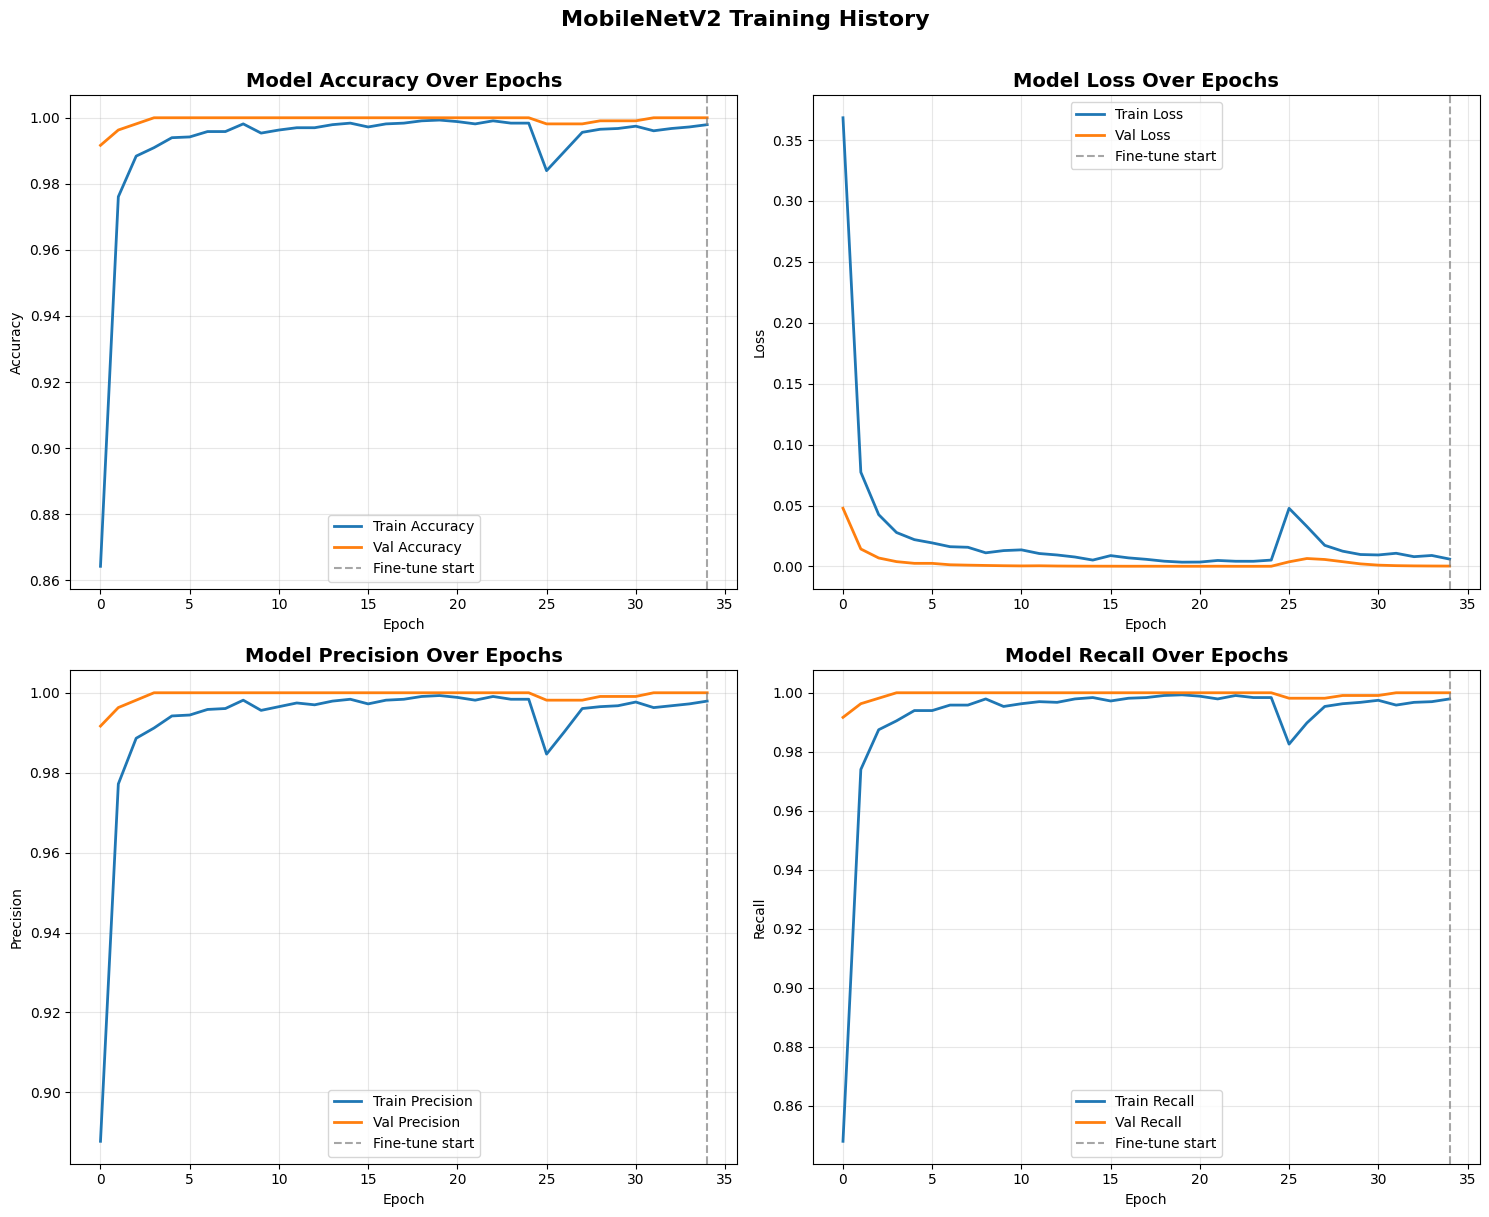

✓ Training history saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/training_history_full.png


In [16]:
# ============================================
# CELL 15: Plot Training History (4 Metrics)
# ============================================
def merge_histories(h1, h2=None):
    """Merge phase-1 and optional fine-tuning histories for plotting."""
    merged = {}
    keys = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'precision', 'val_precision', 'recall', 'val_recall']
    for k in keys:
        merged[k] = h1.history.get(k, [])
        if h2 is not None:
            merged[k] += h2.history.get(k, [])
    return merged

combined = merge_histories(history, history_ft)
total_epochs_run = len(combined['accuracy'])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('MobileNetV2 Training History', fontsize=16, fontweight='bold', y=1.01)

# Draw a vertical line to separate phase 1 and fine-tuning (if applicable)
phase1_ep = len(history.history['accuracy'])

for ax, train_key, val_key, title, ylabel in [
    (axes[0, 0], 'accuracy',  'val_accuracy',  'Model Accuracy',   'Accuracy'),
    (axes[0, 1], 'loss',      'val_loss',      'Model Loss',       'Loss'),
    (axes[1, 0], 'precision', 'val_precision', 'Model Precision',  'Precision'),
    (axes[1, 1], 'recall',    'val_recall',    'Model Recall',     'Recall'),
]:
    ax.plot(combined[train_key], label=f'Train {ylabel}', linewidth=2)
    ax.plot(combined[val_key],   label=f'Val {ylabel}',   linewidth=2)
    if FINE_TUNE and history_ft is not None:
        ax.axvline(x=phase1_ep - 1, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
    ax.set_title(f'{title} Over Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'training_history_full.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training history saved to: {base_path}/training_history_full.png")


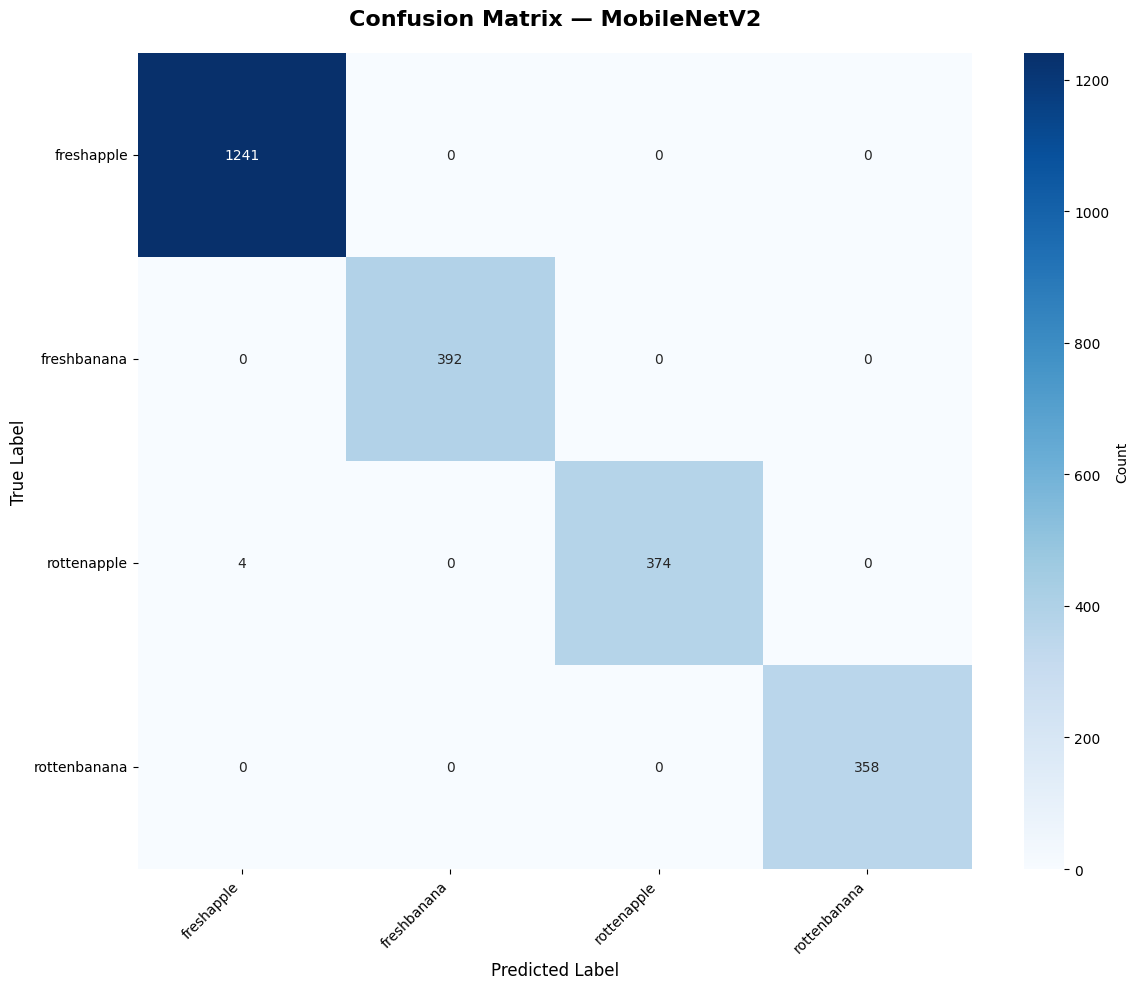

✓ Confusion matrix saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/confusion_matrix.png


In [17]:
# ============================================
# CELL 16: Plot Confusion Matrix
# ============================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix — MobileNetV2', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix saved to: {base_path}/confusion_matrix.png")


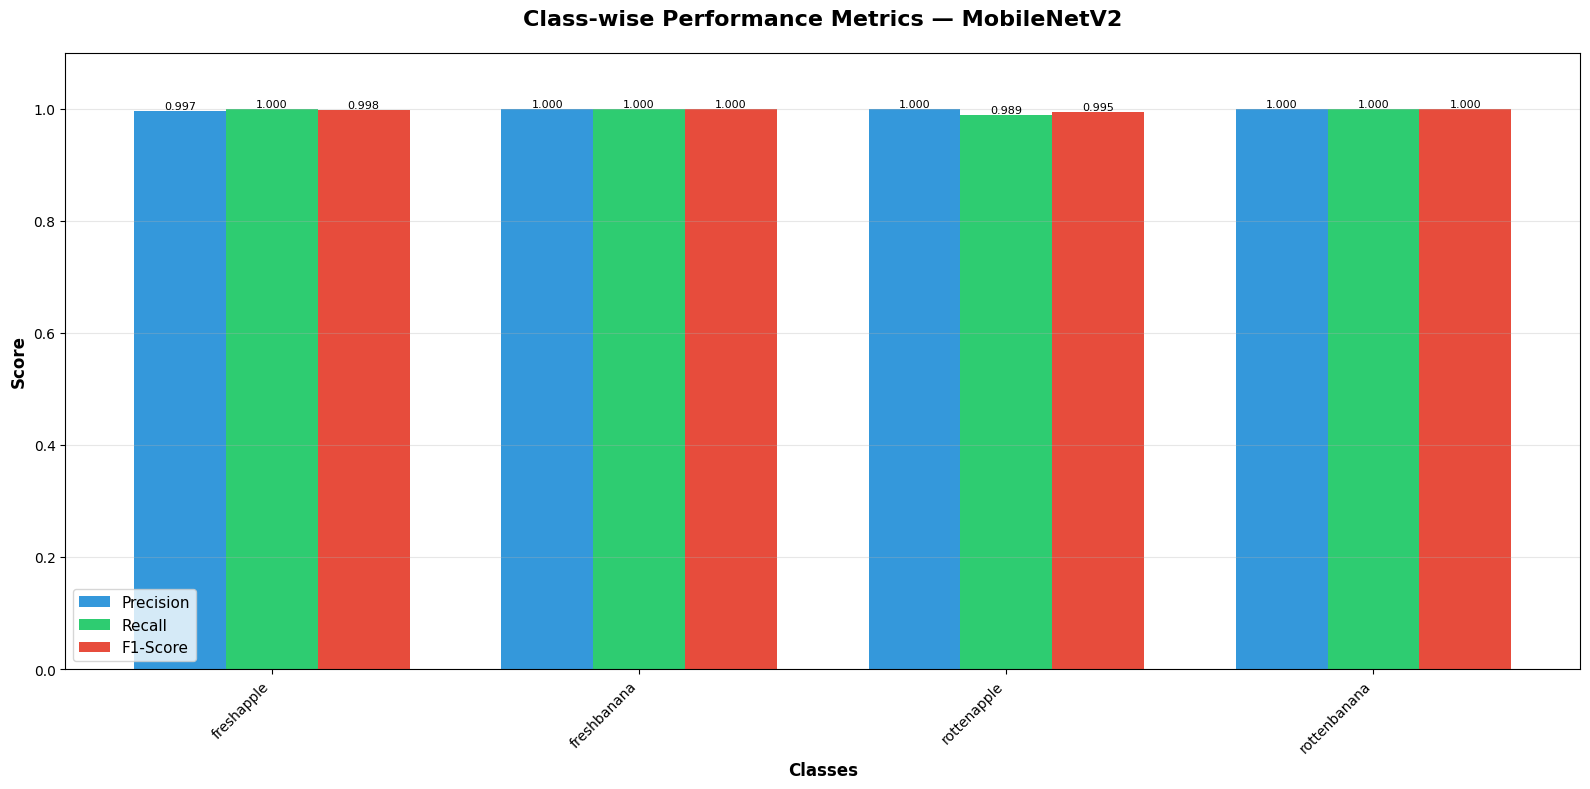

✓ Class-wise performance saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/class_wise_performance.png


In [18]:
# ============================================
# CELL 17: Plot Class-wise Performance
# ============================================
classes_list = list(report.keys())[:-3]

metrics = {
    'Precision': [report[c]['precision'] for c in classes_list],
    'Recall':    [report[c]['recall']    for c in classes_list],
    'F1-Score':  [report[c]['f1-score']  for c in classes_list]
}

x = np.arange(len(classes_list))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 8))
bars1 = ax.bar(x - width, metrics['Precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x,         metrics['Recall'],    width, label='Recall',    color='#2ecc71')
bars3 = ax.bar(x + width, metrics['F1-Score'],  width, label='F1-Score',  color='#e74c3c')

ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Score',   fontsize=12, fontweight='bold')
ax.set_title('Class-wise Performance Metrics — MobileNetV2',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classes_list, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'class_wise_performance.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Class-wise performance saved to: {base_path}/class_wise_performance.png")




COMPREHENSIVE METRICS TABLE
   Dataset  Accuracy     Loss  Precision   Recall
  Training  0.997911 0.005991   0.997911 0.997911
Validation  1.000000 0.000273   1.000000 1.000000
      Test  0.998312 0.007201   0.998312 0.998312


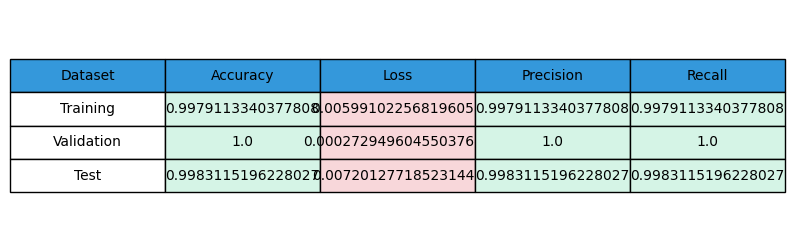

✓ Metrics table saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/metrics_table.png
✓ Metrics summary saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/metrics_summary.csv


In [19]:
# ============================================
# CELL 18: Create Comprehensive Metrics Table
# ============================================
final_epoch = len(combined['accuracy']) - 1

metrics_data = {
    'Dataset':   ['Training', 'Validation', 'Test'],
    'Accuracy':  [combined['accuracy'][final_epoch],  combined['val_accuracy'][final_epoch],  test_metrics['accuracy']],
    'Loss':      [combined['loss'][final_epoch],       combined['val_loss'][final_epoch],       test_metrics['loss']],
    'Precision': [combined['precision'][final_epoch],  combined['val_precision'][final_epoch],  test_metrics['precision']],
    'Recall':    [combined['recall'][final_epoch],     combined['val_recall'][final_epoch],     test_metrics['recall']],
}

df_metrics = pd.DataFrame(metrics_data)

print("\n" + "="*70)
print("COMPREHENSIVE METRICS TABLE")
print("="*70)
print(df_metrics.to_string(index=False))
print("="*70)

df_metrics.to_csv(os.path.join(base_path, 'metrics_summary.csv'), index=False)

# Visual table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns,
                 cellLoc='center', loc='center',
                 colColours=['#3498db'] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(1, len(df_metrics) + 1):
    for j in range(len(df_metrics.columns)):
        cell = table[(i, j)]
        if j > 0:
            try:
                value = float(df_metrics.iloc[i-1, j])
                if value >= 0.9:
                    cell.set_facecolor('#d5f4e6')
                elif value >= 0.8:
                    cell.set_facecolor('#fff3cd')
                else:
                    cell.set_facecolor('#f8d7da')
            except:
                pass

plt.savefig(os.path.join(base_path, 'metrics_table.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Metrics table saved to: {base_path}/metrics_table.png")
print(f"✓ Metrics summary saved to: {base_path}/metrics_summary.csv")



In [20]:
# ============================================
# CELL 19: Create Epoch-wise Metrics Table (all phases)
# ============================================
epochs_data = {
    'Epoch':          list(range(1, total_epochs_run + 1)),
    'Phase':          ['Feature Extraction'] * phase1_ep + (['Fine-Tuning'] * len(combined['accuracy'][phase1_ep:]) if FINE_TUNE else []),
    'Train_Acc':      combined['accuracy'],
    'Val_Acc':        combined['val_accuracy'],
    'Train_Loss':     combined['loss'],
    'Val_Loss':       combined['val_loss'],
    'Train_Precision':combined['precision'],
    'Val_Precision':  combined['val_precision'],
    'Train_Recall':   combined['recall'],
    'Val_Recall':     combined['val_recall'],
}

df_epochs = pd.DataFrame(epochs_data)
df_epochs.to_csv(os.path.join(base_path, 'epoch_wise_metrics.csv'), index=False)

print("\n" + "="*130)
print(f"EPOCH-WISE TRAINING METRICS (ALL {total_epochs_run} EPOCHS)")
print("="*130)
print(df_epochs.to_string(index=False))
print("="*130)
print(f"\n✓ Epoch-wise metrics saved to: {base_path}/epoch_wise_metrics.csv")



EPOCH-WISE TRAINING METRICS (ALL 35 EPOCHS)
 Epoch              Phase  Train_Acc  Val_Acc  Train_Loss  Val_Loss  Train_Precision  Val_Precision  Train_Recall  Val_Recall
     1 Feature Extraction   0.864238 0.991659    0.368330  0.047738         0.887755       0.991659      0.847993    0.991659
     2 Feature Extraction   0.976097 0.996293    0.077318  0.014288         0.977183       0.996293      0.974008    0.996293
     3 Feature Extraction   0.988396 0.998146    0.042513  0.006925         0.988615       0.998146      0.987468    0.998146
     4 Feature Extraction   0.990949 1.000000    0.027826  0.003919         0.991175       1.000000      0.990485    1.000000
     5 Feature Extraction   0.993966 1.000000    0.021975  0.002520         0.994197       1.000000      0.993966    1.000000
     6 Feature Extraction   0.994198 1.000000    0.019292  0.002505         0.994428       1.000000      0.993966    1.000000
     7 Feature Extraction   0.995823 1.000000    0.016177  0.001348      

In [21]:
# ============================================
# CELL 20: Save Final Model (.H5 Format)
# ============================================
final_model_path = os.path.join(base_path, 'fruit_classifier_final_model.h5')
model.save(final_model_path)
print(f"✓ Final model saved to: {final_model_path}")

✓ Final model saved to: /content/drive/MyDrive/FinalYearProject/fruits_dataset/fruit_classifier_final_model.h5


In [29]:
# ============================================
# CELL 21: Convert Model to TensorFlow Lite (.tflite)
# ============================================
print("\n" + "="*70)
print("CONVERTING MODEL TO TENSORFLOW LITE")
print("="*70)

# ── Step 1: Rebuild the model architecture (avoids Lambda deserialization issue) ──
# We reconstruct a fresh model with the same architecture, load the saved weights,
# then wrap it with a concrete preprocessing layer for TFLite compatibility.

def build_mobilenet_for_export(num_classes, img_size=IMG_SIZE):
    """
    Rebuild MobileNetV2 model using a concrete preprocessing layer instead of Lambda.
    This is fully serializable and TFLite-compatible.
    """
    base_model = MobileNetV2(
        weights=None,           # Weights will be loaded separately
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Use Rescaling layer (native Keras layer — no Lambda, fully serializable)
    # Converts [0,1] → [-1,1] as MobileNetV2 expects: x = (x - 0.5) * 2
    x = layers.Rescaling(scale=2.0, offset=-1.0, name='mobilenetv2_preprocessing')(inputs)

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn_top')(x)
    x = layers.Dense(256, activation='relu', name='dense_256')(x)
    x = layers.Dropout(0.5, name='dropout_top')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    export_model = keras.Model(inputs, outputs, name='MobileNetV2_FruitClassifier_Export')
    return export_model

# ── Step 2: Build export model and transfer weights from the trained model ────
print("  Rebuilding model architecture for export...")
export_model = build_mobilenet_for_export(num_classes)

# Transfer weights layer by layer by name (robust across architectures)
for layer in export_model.layers:
    try:
        src_layer = model.get_layer(layer.name)
        layer.set_weights(src_layer.get_weights())
    except (ValueError, Exception):
        pass  # Skip layers with no weights or name mismatch

print("  ✓ Weights transferred to export model")

# ── Step 3: Convert to TFLite ─────────────────────────────────────────────────
converter = tf.lite.TFLiteConverter.from_keras_model(export_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]   # Dynamic range quantization
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

tflite_model_path = os.path.join(base_path, 'fruit_classifier_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

tflite_size_mb = os.path.getsize(tflite_model_path) / (1024 * 1024)
print(f"✓ TensorFlow Lite model saved to: {tflite_model_path}")
print(f"  Model size: {tflite_size_mb:.2f} MB")
print("  Optimized for Android / iOS / edge deployment via dynamic range quantization")

# ── Step 4: Quick sanity check — run one test batch through the TFLite model ──
print("\n  Running TFLite inference sanity check...")
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Grab one batch from test generator
test_generator.reset()
sample_batch, sample_labels = next(test_generator)
sample_image = np.expand_dims(sample_batch[0], axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], sample_image)
interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])

tflite_pred_class = class_names[np.argmax(tflite_output)]
true_class        = class_names[np.argmax(sample_labels[0])]
print(f"  Sample — True: {true_class:15s} | TFLite Predicted: {tflite_pred_class}")
print(f"  ✓ TFLite model is working correctly!")



CONVERTING MODEL TO TENSORFLOW LITE
  Rebuilding model architecture for export...
  ✓ Weights transferred to export model
Saved artifact at '/tmp/tmpaq0glfsw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1436')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133974734916496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734917648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734918608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734918224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734918416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734916880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734918032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133974734915920: TensorSpe

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [30]:
# ============================================
# CELL 22: Create Model Metadata File
# ============================================
metadata = {
    'Model Name':           'Fruit Classifier (Fresh vs Rotten) — MobileNetV2',
    'Base Architecture':    'MobileNetV2 (pretrained on ImageNet)',
    'Classes':              str(classes),
    'Image Size':           f'{IMG_SIZE}x{IMG_SIZE}',
    'Number of Classes':    num_classes,
    'Fine-Tuning':          f"{'Enabled' if FINE_TUNE else 'Disabled'}"
                            + (f" (top {FINE_TUNE_LAYERS} layers)" if FINE_TUNE else ""),
    'Training Epochs':      EPOCHS,
    'Fine-Tune Epochs':     FINE_TUNE_EPOCHS if FINE_TUNE else 'N/A',
    'Batch Size':           BATCH_SIZE,
    'Final Test Accuracy':  f"{test_accuracy*100:.2f}%",
    'Final Test F1-Score':  f"{test_f1:.4f}",
    'Final Test Precision': f"{test_precision:.4f}",
    'Final Test Recall':    f"{test_recall:.4f}",
    'Total Training Time':  str(training_time),
    'TFLite Model Size':    f"{tflite_size_mb:.2f} MB",
    'Input Format':         'RGB Image — rescaled to [0,1] by generator; preprocessed to [-1,1] inside model',
    'Output Format':        'Class probabilities (softmax)',
}

metadata_df = pd.DataFrame(list(metadata.items()), columns=['Property', 'Value'])
metadata_df.to_csv(os.path.join(base_path, 'model_metadata.csv'), index=False)

print("\n" + "="*70)
print("MODEL METADATA")
print("="*70)
print(metadata_df.to_string(index=False))
print("="*70)


MODEL METADATA
            Property                                                                           Value
          Model Name                                Fruit Classifier (Fresh vs Rotten) — MobileNetV2
   Base Architecture                                            MobileNetV2 (pretrained on ImageNet)
             Classes                    ['freshapple', 'freshbanana', 'rottenapple', 'rottenbanana']
          Image Size                                                                         224x224
   Number of Classes                                                                               4
         Fine-Tuning                                                         Enabled (top 30 layers)
     Training Epochs                                                                              25
    Fine-Tune Epochs                                                                              10
          Batch Size                                                       

In [31]:
# ============================================
# CELL 23: Final Summary Report
# ============================================
print("\n" + "="*70)
print("✓ TRAINING AND ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📁 GENERATED FILES:")
print("-" * 70)
print(f"  1. Final Model (.H5):              fruit_classifier_final_model.h5")
print(f"  2. Best Model (.H5):               best_model.h5")
if FINE_TUNE:
    print(f"  3. Best Fine-Tuned Model (.H5):    best_model_finetuned.h5")
print(f"  4. TensorFlow Lite Model:          fruit_classifier_model.tflite")
print(f"  5. Training History Graph:         training_history_full.png")
print(f"  6. Confusion Matrix:               confusion_matrix.png")
print(f"  7. Class Performance Graph:        class_wise_performance.png")
print(f"  8. Metrics Table (Visual):         metrics_table.png")
print(f"  9. Metrics Summary (CSV):          metrics_summary.csv")
print(f" 10. Epoch-wise Metrics (CSV):       epoch_wise_metrics.csv")
print(f" 11. Classification Report (CSV):    classification_report.csv")
print(f" 12. Dataset Summary (CSV):          dataset_summary.csv")
print(f" 13. Model Metadata (CSV):           model_metadata.csv")
print("-" * 70)

print("\n📊 FINAL RESULTS:")
print("-" * 70)
print(f"  Training Accuracy (last epoch):    {combined['accuracy'][final_epoch]*100:.2f}%")
print(f"  Validation Accuracy (last epoch):  {combined['val_accuracy'][final_epoch]*100:.2f}%")
print(f"  Test Accuracy:                     {test_accuracy*100:.2f}%")
print(f"  Test Precision:                    {test_precision:.4f}")
print(f"  Test Recall:                       {test_recall:.4f}")
print(f"  Test F1-Score:                     {test_f1:.4f}")
print(f"  Total Training Time:               {training_time}")
print(f"  TFLite Model Size:                 {tflite_size_mb:.2f} MB")
print("-" * 70)

print(f"\n📂 All files saved to: {base_path}")
print("\n🚀 MODEL USAGE:")
print("-" * 70)
print("  H5 Model:     Use with TensorFlow/Keras in Python")
print("  TFLite Model: Deploy on Android / iOS / Raspberry Pi / edge devices")
print("="*70)
print("\n✨ Your MobileNetV2 fruit classification model is ready!")
print("="*70)



✓ TRAINING AND ANALYSIS COMPLETED SUCCESSFULLY!

📁 GENERATED FILES:
----------------------------------------------------------------------
  1. Final Model (.H5):              fruit_classifier_final_model.h5
  2. Best Model (.H5):               best_model.h5
  3. Best Fine-Tuned Model (.H5):    best_model_finetuned.h5
  4. TensorFlow Lite Model:          fruit_classifier_model.tflite
  5. Training History Graph:         training_history_full.png
  6. Confusion Matrix:               confusion_matrix.png
  7. Class Performance Graph:        class_wise_performance.png
  8. Metrics Table (Visual):         metrics_table.png
  9. Metrics Summary (CSV):          metrics_summary.csv
 10. Epoch-wise Metrics (CSV):       epoch_wise_metrics.csv
 11. Classification Report (CSV):    classification_report.csv
 12. Dataset Summary (CSV):          dataset_summary.csv
 13. Model Metadata (CSV):           model_metadata.csv
----------------------------------------------------------------------

📊 FINAL

In [33]:
print("Thank you so much")


Thank you so much
